In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.model_selection import KFold

In [4]:
# Set the maximum number of columns to display
pd.set_option('display.max_columns', None)

In [5]:
original_data = pd.read_csv('data/sample_submission.csv')
original_data.shape

(3500, 37)

In [6]:
original_data.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,9.545,9.265,8.110,8.43,7.15,0.180,0.200,0.650,14.515,5.845,1.285,0.429,0.030,0.050,0.064,0.730,1.075,0.056,0.567,0.400,1.500,1.560,19.355,4.95,1.730,1.800,4.800,3.15,10.665,10.465,16.645,5.75,10.37
1,1,9.10,13.533,40.90,8.770,9.265,6.015,10.07,7.15,1.107,1.027,1.848,8.625,12.175,0.280,0.440,0.089,1.360,0.064,0.902,1.454,0.056,0.190,2.347,5.105,2.095,19.355,20.05,9.530,7.695,4.550,6.95,2.040,5.200,5.725,2.95,2.23
2,2,8.21,3.710,5.42,8.770,9.265,4.550,10.07,7.15,0.020,0.020,0.650,17.144,24.645,0.380,0.440,0.060,0.050,0.082,0.902,2.025,0.056,0.567,1.700,1.700,3.960,4.900,4.58,3.025,3.960,4.935,4.95,4.725,6.075,6.750,3.50,3.17
3,3,8.39,8.700,8.10,9.500,9.200,5.200,8.67,6.67,0.280,0.270,1.730,3.870,8.410,1.480,1.380,0.050,0.050,0.070,0.530,1.740,0.050,0.064,1.500,1.500,2.020,3.960,8.45,2.070,1.730,6.300,4.70,3.500,6.200,8.670,2.90,7.37
4,4,8.07,8.050,8.65,7.960,9.265,3.290,10.07,7.15,0.360,0.435,0.650,3.850,5.845,0.280,0.440,0.105,0.115,0.074,1.252,1.075,0.071,0.190,1.050,1.150,2.095,3.902,2.02,1.730,0.760,4.800,4.97,3.950,2.800,8.400,3.50,3.90


In [7]:
num_feature = original_data.columns.drop(['id', 'target'])
target = 'target'

In [ ]:
# Is there any missing data?
is_null_result = original_data.isnull().sum()
is_nan_result = original_data.isna().sum()

# Print a warning if there is any missing data
if is_null_result.sum() > 0:
    print('Warning: There is missing data')
else:
    print('There is no missing data')

# Print a warning if there is any nan data
if is_nan_result.sum() > 0:
    print('Warning: There is nan data')
else:
    print('There is no nan data')

In [ ]:
# Remove the id column
original_data.head()

In [ ]:
# Display a boxplot of each columns
original_data.boxplot(figsize=(20, 3))

In [ ]:
# Display more information on the dataset
original_data.describe(include='all')

The column NH4_5 seems to have a outlier. We will delete this element before going further.

In [ ]:
# Delete the row with the outlier

# Delete the row with the maximum value in the column `NH4_5`
transformed_dataset = original_data.copy()
transformed_dataset = transformed_dataset.drop(transformed_dataset['NH4_5'].idxmax())

# Display the informations of the dataset
transformed_dataset.describe(include='all')

In [ ]:
# Redisplay the boxplot of each columns
transformed_dataset.drop(columns=['id'], axis=1).boxplot(figsize=(20, 3))
plt.show()

In [ ]:
# Display an histogram of each columns
transformed_dataset.drop(columns=['id'], axis=1).hist(figsize=(20, 10), bins=50)
plt.show()

In [ ]:
# Display the correlation matrix
corr_matrix = transformed_dataset.drop(columns=['id'], axis=1).corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.show()


We know which model will be used, so we can train it with the training we have and use k-fold cross validation to test every methods.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Create a dataframe that will contain the score of each methods
kfold_results = pd.DataFrame(columns=['Description', 'MSE', 'MAE'])

# Function that will train a model with a kfold based on the dataset in parameter and will
# calculate the mean squared error and the mean absolute error. 
def kfold_train_model(df: pd.DataFrame, description: str, features: list, fold: int = 5):
    global kfold_results
    X = df[features]
    y = df[target]
    rf = RandomForestRegressor(n_estimators=1000, max_depth=7, n_jobs=-1, random_state=42)
    
    kf = KFold(n_splits=fold, shuffle=True, random_state=42)

    mse_scores = []
    mae_scores = []

    for train_index, test_index in kf.split(X):
        # Split data into training and testing sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train the model
        rf.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = rf.predict(X_test)
        
        # Calculate Mean Squared Error for this fold
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)

        # Calculate Mean Absolute Error for this fold
        mae = mean_absolute_error(y_test, y_pred)
        mae_scores.append(mae)
    
    # Calculate the mean of the scores
    mse_mean = np.mean(mse_scores)
    mae_mean = np.mean(mae_scores)

    # Append the scores to the dataframe
    kfold_results = pd.concat([kfold_results, pd.DataFrame({'Description': description, 'MSE': mse_mean, 'MAE': mae_mean}, index=[0])], ignore_index=True)


In [ ]:
# Train the model with the original dataset
kfold_train_model(df=transformed_dataset.drop(columns=['id'], axis=1), features=num_feature, description='original')

In [ ]:
kfold_results.sort_values(by='MSE')

In [ ]:
# Isolation forest method
from sklearn.ensemble import IsolationForest

iso_df = transformed_dataset.copy()

# Initialize Isolation Forest
clf = IsolationForest(random_state=0)

# Fit and predict outliers
IF = clf.fit(iso_df[num_feature])
outliers = IF.predict(iso_df[num_feature]) == -1

iso_df = iso_df.iloc[~outliers]

In [ ]:
# Train the model with the Z-score dataset
kfold_train_model(df=iso_df.copy(), features=num_feature, description='Isolation Forest')

In [ ]:
kfold_results.sort_values(by='MSE')

In [ ]:
# Create a function to zeroed all the columns except the target and the columns in parameter
def zeroed_all_columns_except(dataset: pd.DataFrame, columns_to_keep: list = ['O2_1', 'O2_2', 'target', 'BOD5_5']):
    temp_df = dataset.copy()
    for col in temp_df.columns:
        if col not in columns_to_keep:
            temp_df[col] = 0
    return temp_df

In [ ]:
zeroed_iso_df = zeroed_all_columns_except(iso_df.copy())
kfold_train_model(df=zeroed_iso_df.copy(), features=num_feature, description='Isolation Forest + Zeroed')
kfold_results.sort_values(by='MSE')

In [ ]:
# Test with zeroed before isolation forest
zeroed_df = zeroed_all_columns_except(transformed_dataset.copy())

clf = IsolationForest(random_state=0)
IF = clf.fit(zeroed_df[num_feature])
outliers = IF.predict(zeroed_df[num_feature]) == -1
zeroed_df = zeroed_df.iloc[~outliers]

kfold_train_model(df=zeroed_df.copy(), features=num_feature, description='Zeroed + Isolation Forest')
kfold_results.sort_values(by='MSE')

In [ ]:
zeroed_df.describe(include='all')

In [ ]:
iso_df.describe(include='all')

In [ ]:
original_data.describe(include='all')

In [ ]:
zeroed_iso_df.describe(include='all')

In [ ]:
# Code for the final submission

# on the test set, it seems that the zeroed + iso forest is the best method

# Reload the original dataset
original_data = pd.read_csv('data/sample_submission.csv')

# Zeroed the dataset
zeroed_df = zeroed_all_columns_except(original_data.copy())

# Initialize Isolation Forest
clf = IsolationForest(random_state=0)
IF = clf.fit(zeroed_df[num_feature])
outliers = IF.predict(zeroed_df[num_feature]) == -1
zeroed_df = zeroed_df.iloc[~outliers]

zeroed_df.to_csv('submission.csv', index=False)

In [8]:
df = pd.read_csv('data/sample_submission.csv')

df.target = df.target.clip(7,20)

# SGD
clf = SGDOneClassSVM(nu=0.55).fit(df[num_feature])
outlier_indices = clf.predict(df[num_feature]) == -1
df = df.iloc[~outlier_indices]

# IsolationForest
lf = IsolationForest(random_state=0).fit(df[num_feature])
outlier_indices = clf.predict(df[num_feature]) == -1
df = df.iloc[~outlier_indices]

# LOF
lof = LocalOutlierFactor(n_neighbors=3, contamination=0.1)
outlier_indices = lof.fit_predict(df[num_feature]) == -1
df = df.iloc[~outlier_indices]

lowest_quality_labels =  [2365, 1089, 1936, 1680, 211,2294,448, 437,309,1684]
df = df.iloc[~df.index.isin(lowest_quality_labels)]

df = df[df.target != 7]
# df = df[df.target != 20]
# drop_index = np.random.choice(df[df['target']==7].index.to_numpy(), 130, replace=False)
# drop_index = drop_index.tolist()
# drop_index.extend(lowest_quality_labels)
# df = df.iloc[~df.index.isin(drop_index)]


col_to_keep = ['O2_1', 'O2_2', 'BOD5_5', 'target']

for i in df.columns:
    if i not in col_to_keep:
        df[i]=0
        
df.to_csv('submission.csv', index=False)

In [9]:
df.describe(include='all')

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,NH4_2,NH4_3,NH4_4,NH4_5,NH4_6,NH4_7,NO2_1,NO2_2,NO2_3,NO2_4,NO2_5,NO2_6,NO2_7,NO3_1,NO3_2,NO3_3,NO3_4,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
count,2945.0,2945.000000,2945.000000,2945.000000,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.0,2945.000000,2945.0,2945.0
mean,0.0,8.556978,8.310078,9.204682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.703842,0.0,0.0
std,0.0,1.286640,3.012390,6.440485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.265058,0.0,0.0
min,0.0,7.010000,1.490000,2.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.020000,0.0,0.0
25%,0.0,7.490000,7.170000,7.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.725000,0.0,0.0
50%,0.0,8.390000,7.933000,8.300000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.370000,0.0,0.0
75%,0.0,9.110000,9.100000,8.700000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.400000,0.0,0.0
max,0.0,20.000000,46.950000,45.900000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.725000,0.0,0.0


In [10]:
kfold_train_model(df=df.copy(), features=num_feature, description='From outside')
kfold_results.sort_values(by='MSE')

NameError: name 'kfold_train_model' is not defined

Test with VAE

In [12]:
import pandas as pd
import numpy as np

# Keep only the columns that we want to use
X = df[['O2_1', 'O2_2', 'BOD5_5', 'target']]

# Splitting into train and test
train_size = int(0.8 * len(df))
X_train = X[:train_size]
X_test = X[train_size:]


Epoch 1/2000
48/48 [==============================] - 1s 5ms/step - loss: 31422588928.0000 - val_loss: 1273941248.0000
Epoch 2/2000
48/48 [==============================] - 0s 3ms/step - loss: 908019008.0000 - val_loss: 676624192.0000
Epoch 3/2000
48/48 [==============================] - 0s 2ms/step - loss: 1052809920.0000 - val_loss: 789715456.0000
Epoch 4/2000
48/48 [==============================] - 0s 2ms/step - loss: 564043520.0000 - val_loss: 1136804352.0000
Epoch 5/2000
48/48 [==============================] - 0s 2ms/step - loss: 532431488.0000 - val_loss: 465098976.0000
Epoch 6/2000
48/48 [==============================] - 0s 2ms/step - loss: 486811424.0000 - val_loss: 338877152.0000
Epoch 7/2000
48/48 [==============================] - 0s 2ms/step - loss: 349394144.0000 - val_loss: 312328512.0000
Epoch 8/2000
48/48 [==============================] - 0s 2ms/step - loss: 266658768.0000 - val_loss: 369433696.0000
Epoch 9/2000
48/48 [==============================] - 0s 2ms/step -

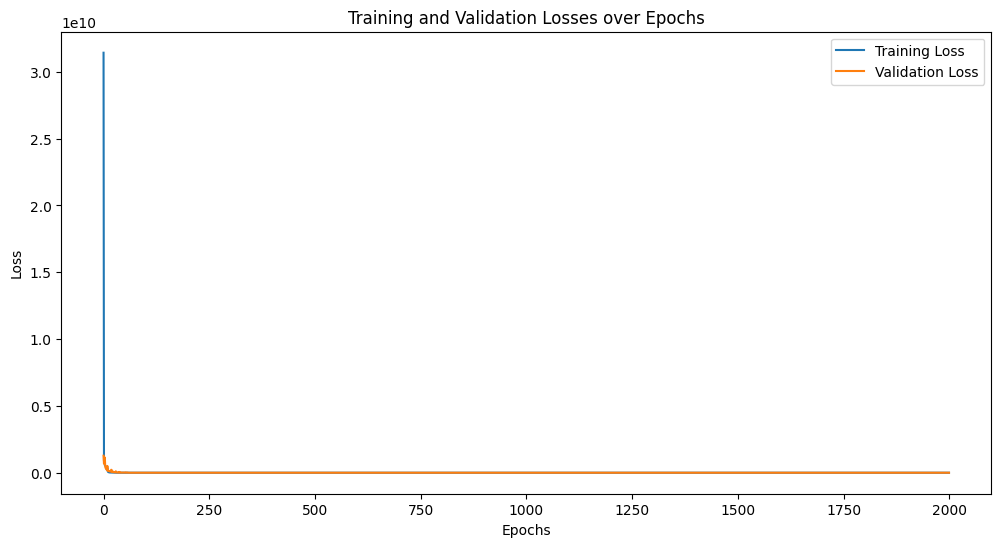

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_squared_error
import matplotlib.pyplot as plt

original_dim = 4
intermediate_dim = 25
latent_dim = 4
batch_size = 50
epochs = 200
epsilon_std = 1.0

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim)
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

vae = Model(x, x_decoded_mean)

xent_loss = original_dim * mean_squared_error(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')

# Train the VAE and capture the history
history = vae.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, X_test))

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses over Epochs')
plt.legend()
plt.show()


12/12 [==============================] - 0s 1ms/step


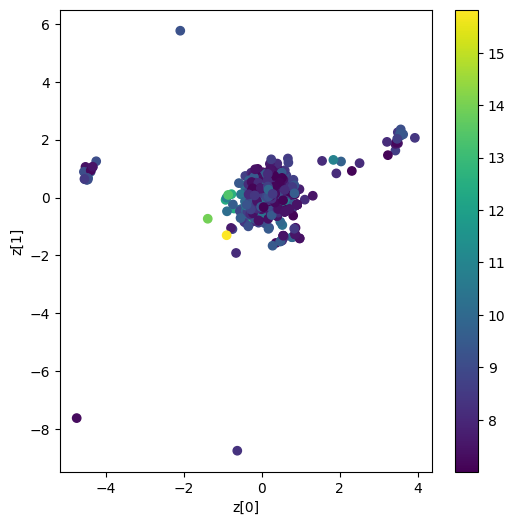

In [24]:
encoder = Model(x, z_mean)
X_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()


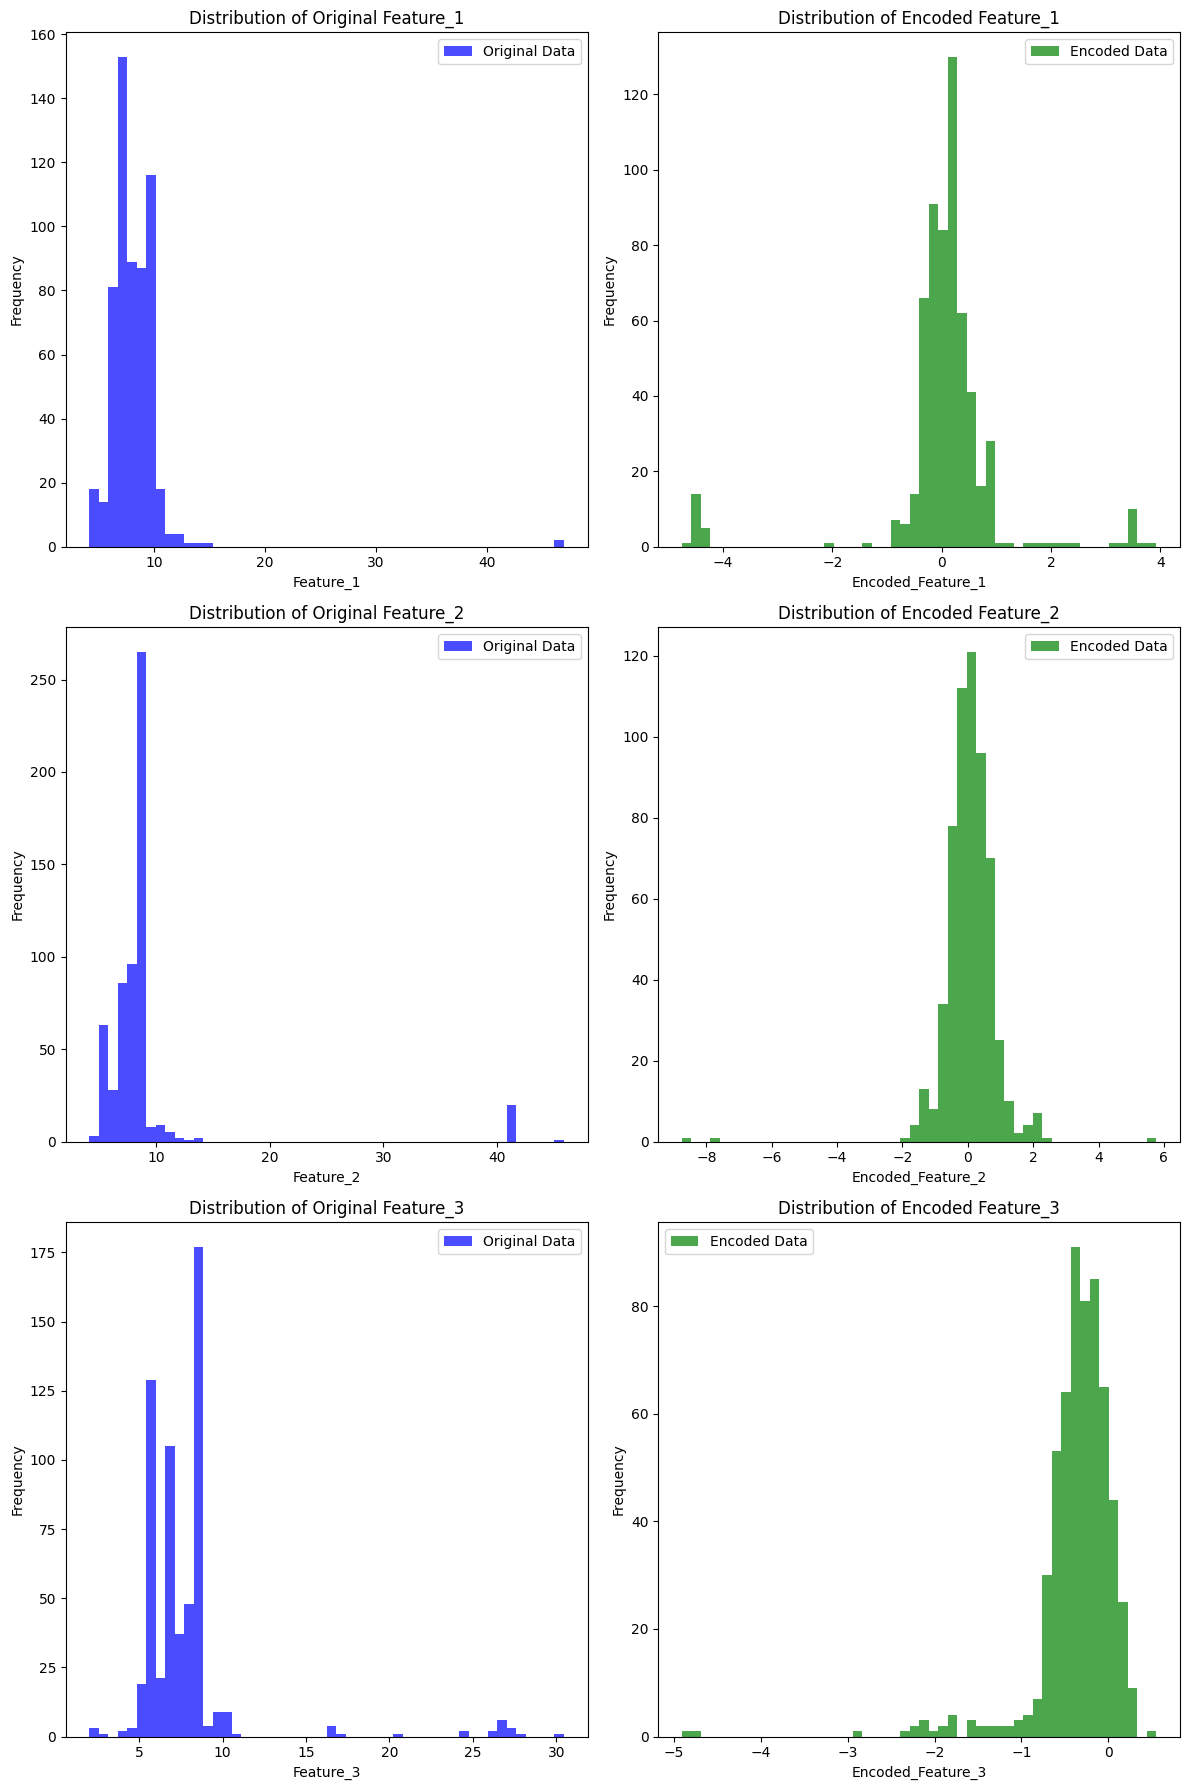

In [25]:
# Total number of features
num_features = 3

# Setting up the figure and axes
fig, axs = plt.subplots(num_features, 2, figsize=(12, 6*num_features))

# Loop through each feature
for i in range(num_features):
    
    # Original Data Histogram
    axs[i, 0].hist(X_test.iloc[:, i], bins=50, color='blue', alpha=0.7, label='Original Data')
    axs[i, 0].set_title(f'Distribution of Original Feature_{i+1}')
    axs[i, 0].set_xlabel(f'Feature_{i+1}')
    axs[i, 0].set_ylabel('Frequency')
    axs[i, 0].legend()
    
    # Generated (Encoded) Data Histogram
    axs[i, 1].hist(X_test_encoded[:, i], bins=50, color='green', alpha=0.7, label='Encoded Data')
    axs[i, 1].set_title(f'Distribution of Encoded Feature_{i+1}')
    axs[i, 1].set_xlabel(f'Encoded_Feature_{i+1}')
    axs[i, 1].set_ylabel('Frequency')
    axs[i, 1].legend()

plt.tight_layout()
plt.show()


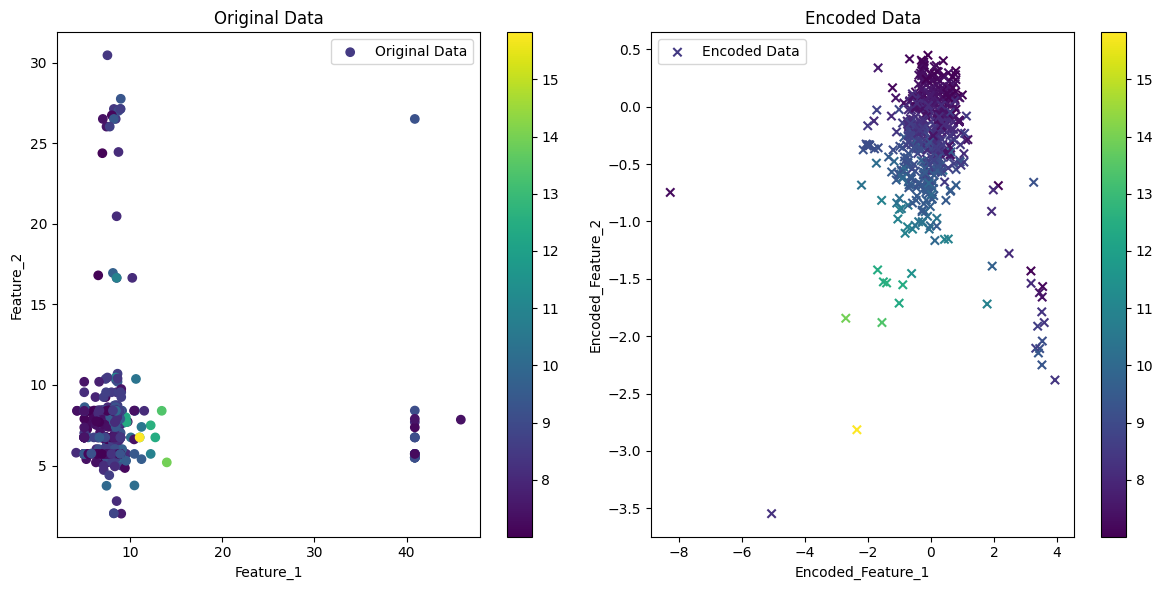

In [16]:
plt.figure(figsize=(12, 6))

# Plotting original X_test data for the first two features
plt.subplot(1, 2, 1)
plt.scatter(X_test.iloc[:, 1], X_test.iloc[:, 2], c=y_test, cmap='viridis', marker='o', label='Original Data')
plt.colorbar()
plt.xlabel("Feature_1")
plt.ylabel("Feature_2")
plt.legend()
plt.title("Original Data")

# Plotting encoded X_test_encoded data
plt.subplot(1, 2, 2)
plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=y_test, cmap='viridis', marker='x', label='Encoded Data')
plt.colorbar()
plt.xlabel("Encoded_Feature_1")
plt.ylabel("Encoded_Feature_2")
plt.legend()
plt.title("Encoded Data")

plt.tight_layout()
plt.show()

In [58]:
X_test_encoded

array([[-0.5591669 , -0.40683818, -0.07130021],
       [-0.38588965, -0.393857  , -0.5926681 ],
       [-0.06884396, -1.0228633 , -0.169967  ],
       ...,
       [-0.52475476, -0.32090032, -0.09663671],
       [ 0.0493055 , -0.6126536 , -0.55042535],
       [-0.4849466 , -0.385844  , -0.09575981]], dtype=float32)